In [2]:
import numpy as np
import pandas as pd

In [3]:
df = pd.read_csv("batminton_data.csv")

In [4]:
df.head(5)

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings
0,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,"Nice product, good quality, but price is now r...",4
1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,They didn't supplied Yonex Mavis 350. Outside ...,1
2,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,Worst product. Damaged shuttlecocks packed in ...,1
3,Suresh Narayanasamy,Fair,"Certified Buyer, Chennai",25.0,1.0,NaN,"Quite O. K. , but nowadays the quality of the...",3
4,ASHIK P A,Over priced,NaN,147.0,24.0,Apr 2016,Over pricedJust â?¹620 ..from retailer.I didn'...,1


In [5]:
df = df[["Review text","Ratings"]]

In [6]:
df.head(5)

,Review text,Ratings
0,"Nice product, good quality, but price is now r...",4
1,They didn't supplied Yonex Mavis 350. Outside ...,1
2,Worst product. Damaged shuttlecocks packed in ...,1
3,"Quite O. K. , but nowadays the quality of the...",3
4,Over pricedJust â?¹620 ..from retailer.I didn'...,1


In [7]:
df["Ratings"].value_counts()

Ratings
5    5080
4    1746
1     769
3     615
2     308
Name: count, dtype: int64

In [8]:
df["Review text"][0]

'Nice product, good quality, but price is now rising which is a bad sign. 800-850 was an affordable price, especially when we play everyday. So kindly help us out in terms of the price. Thank You.READ MORE'

In [9]:
df["Ratings"] = df["Ratings"].map({1:"Negative",2:"Negative",3:"Neutral",4:"Positive",5:"Positive"})
df['Review text'] = (
    df['Review text']
    .str.replace('READ MORE', '', regex=False)
    .str.strip()
)

In [10]:
df.head(2)

,Review text,Ratings
0,"Nice product, good quality, but price is now r...",Positive
1,They didn't supplied Yonex Mavis 350. Outside ...,Negative


In [11]:
df["Ratings"].value_counts()

Ratings
Positive    6826
Negative    1077
Neutral      615
Name: count, dtype: int64

In [12]:
df["Ratings"] = df["Ratings"].map({"Negative":"0","Neutral":"1","Positive":"2"})
df["Ratings"] = df["Ratings"].astype("int")

In [13]:
df.isna().sum()
df = df.dropna()

In [14]:
df["Review text"].duplicated().sum()
df = df.drop_duplicates()

In [ ]:
%pip install nltk


[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
import nltk
import re
# nltk.download('stopwords')
# nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords

In [17]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

In [18]:
def clean_text(text):
    if pd.isna(text):
        return ""

    text = text.lower()                            # lowercase
    text = re.sub(r"http\S+", "", text)            # remove URLs
    text = re.sub(r"@\w+", "", text)               # remove mentions
    text = re.sub(r"#", "", text)                  # remove hashtag symbol
    text = re.sub(r"[^a-z\s]", "", text)           # remove numbers & symbols

    words = text.split()
    words = [
        lemmatizer.lemmatize(word)
        for word in words
        if word not in stop_words
    ]

    return " ".join(words)

In [19]:
df["cleaned_review"] = df["Review text"].apply(clean_text)
df.head(2)

,Review text,Ratings,cleaned_review
0,"Nice product, good quality, but price is now r...",2,nice product good quality price rising bad sig...
1,They didn't supplied Yonex Mavis 350. Outside ...,0,didnt supplied yonex mavis outside cover yonex...


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

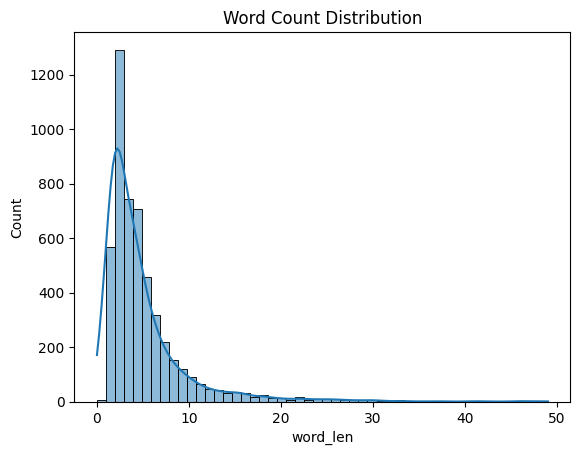

In [21]:
df["word_len"] = df["cleaned_review"].str.split().str.len()

sns.histplot(df["word_len"], bins=50, kde=True)
plt.title("Word Count Distribution")
plt.show()

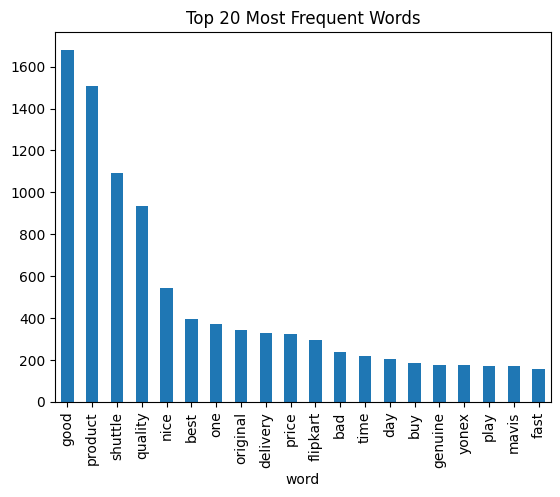

In [22]:
from collections import Counter

words = " ".join(df["cleaned_review"]).split()
word_freq = Counter(words).most_common(20)

pd.DataFrame(word_freq, columns=["word","count"]).plot(
    x="word", y="count", kind="bar", legend=False
)
plt.title("Top 20 Most Frequent Words")
plt.show()

In [23]:
from sklearn.model_selection import train_test_split
X = df["cleaned_review"]
y = df["Ratings"]


X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

count_vectorizer = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer()

In [25]:
X_train_cv = count_vectorizer.fit_transform(X_train)
X_test_cv = count_vectorizer.transform(X_test)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [26]:
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC

In [27]:
model_dictionary = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "RandomForestClassifier": RandomForestClassifier(n_jobs=-1),
    "MultinomialNB": MultinomialNB(),
    "XGBClassifier": XGBClassifier(
        objective="multi:softprob",
        num_class=3,
        eval_metric="mlogloss",
        use_label_encoder=False
    ),
    "LinearSVC": LinearSVC()
}
f1_dict = {}

In [28]:
from sklearn.base import clone
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm

f1_dict = {}

for name, model in tqdm(model_dictionary.items(), desc="Training models"):
    model_clone = clone(model)
    model_clone.fit(X_train_cv, y_train)
    y_pred = model_clone.predict(X_test_cv)
    f1_dict[name] = f1_score(y_test, y_pred, average="macro")

Training models: 100%|██████████| 6/6 [00:02<00:00,  2.32it/s]


In [29]:
pd.DataFrame({"Model Name":list(model_dictionary.keys()),"F1 Score":list(f1_dict.values())}).sort_values(by = "F1 Score",ascending=False).reset_index(drop = True)

,Model Name,F1 Score
0,LinearSVC,0.563679
1,RandomForestClassifier,0.563409
2,LogisticRegression,0.546797
3,XGBClassifier,0.544080
4,MultinomialNB,0.537963
5,KNeighborsClassifier,0.526417


In [30]:
f1_dict = {}

for name, model in tqdm(model_dictionary.items(), desc="Training models"):
    model_clone = clone(model)
    model_clone.fit(X_train_tfidf, y_train)
    y_pred = model_clone.predict(X_test_tfidf)
    f1_dict[name] = f1_score(y_test, y_pred, average="macro")

Training models: 100%|██████████| 6/6 [00:03<00:00,  1.56it/s]


In [31]:
pd.DataFrame({"Model Name":list(model_dictionary.keys()),"F1 Score":list(f1_dict.values())}).sort_values(by = "F1 Score",ascending=False).reset_index(drop = True)

,Model Name,F1 Score
0,LinearSVC,0.547484
1,RandomForestClassifier,0.543944
2,XGBClassifier,0.540093
3,LogisticRegression,0.521353
4,KNeighborsClassifier,0.513549
5,MultinomialNB,0.438530


In [32]:
rf = RandomForestClassifier()
rf.fit(X_train_cv, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [33]:
y_pred  = rf.predict(X_test_cv)

In [34]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.59      0.63       277
           1       0.25      0.11      0.15       133
           2       0.85      0.93      0.89      1115

    accuracy                           0.80      1525
   macro avg       0.59      0.54      0.56      1525
weighted avg       0.77      0.80      0.78      1525



In [35]:
import joblib

joblib.dump(rf, "model.joblib")

['model.joblib']

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# Create the pipeline
pipe = Pipeline([
    ('count_vectorizer', CountVectorizer()),
    ('rf_classifier', RandomForestClassifier(n_jobs=-1))
])

# Train the pipeline
pipe.fit(X_train, y_train)

# Function to predict sentiment for raw text
def predict_review(text):
    cleaned_review = clean_text(text)
    prediction = pipe.predict([cleaned_review])[0]
    Sentiment_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
    return Sentiment_map[prediction]

# Example usage
sample_review = "This product is amazing! I love it."
print(f"Review: {sample_review}")
print(f"Predicted Sentiment: {predict_review(sample_review)}")

sample_review_neg = "Worst purchase ever. Waste of money."
print(f"\nReview: {sample_review_neg}")
print(f"Predicted Sentiment: {predict_review(sample_review_neg)}")

Review: This product is amazing! I love it.
Predicted Sentiment: Positive

Review: Worst purchase ever. Waste of money.
Predicted Sentiment: Negative
